In [18]:
# =========================
# Cell 1: Imports + paths + reproducibility (required)
# =========================

import os, re, csv, json, random
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

PROJECT_ROOT = "."
DATA_DIR = os.path.join(PROJECT_ROOT, "Amazon_products")

TRAIN_CORPUS_PATH = os.path.join(DATA_DIR, "train", "train_corpus.txt")
TEST_CORPUS_PATH  = os.path.join(DATA_DIR, "test",  "test_corpus.txt")

CLASSES_PATH = os.path.join(DATA_DIR, "classes.txt")
HIER_PATH    = os.path.join(DATA_DIR, "class_hierarchy.txt")
KEYWORD_PATH = os.path.join(DATA_DIR, "class_related_keywords.txt")

ART_DIR = os.path.join(PROJECT_ROOT, "artifacts_Experiment4_GAT")
os.makedirs(ART_DIR, exist_ok=True)

NUM_CLASSES = 531
MIN_LABELS = 2
MAX_LABELS = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [19]:
# =========================
# Cell 2: Clean + Load Corpus
# =========================

TAG_RE = re.compile(r"<[^>]+>")

def clean_text(s: str) -> str:
    s = s or ""
    s = TAG_RE.sub(" ", s)
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def load_corpus(path: str):
    pid2text = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                pid, text = parts
                pid2text[pid] = clean_text(text)
    return pid2text

pid2text_train = load_corpus(TRAIN_CORPUS_PATH)
pid2text_test  = load_corpus(TEST_CORPUS_PATH)
id_list_test   = list(pid2text_test.keys())

print("train:", len(pid2text_train), "test:", len(pid2text_test))


train: 29487 test: 19658


In [20]:
# =========================
# Cell 3: Load classes (robust) + hierarchy + adjacency matrix A_hat
# =========================

def load_classes(path):
    """
    Supports:
      - 'id<TAB>class name with spaces'
      - OR 'id<space>class name with spaces'
      - OR name-only per line
    """
    name2id, id2name = {}, {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            m = re.match(r"^(\d+)\s+(.+)$", line)
            if m:
                cid = int(m.group(1))
                cname = m.group(2).strip()
            else:
                parts = line.split("\t")
                if len(parts) == 2 and parts[0].isdigit():
                    cid = int(parts[0])
                    cname = parts[1].strip()
                else:
                    cid = len(id2name)
                    cname = line

            name2id[cname] = cid
            id2name[cid] = cname

    return name2id, id2name

name2id, id2name = load_classes(CLASSES_PATH)
assert len(id2name) == NUM_CLASSES, f"Expected {NUM_CLASSES}, got {len(id2name)}"
print("num classes loaded:", len(id2name))

def load_hierarchy(path):
    parents = defaultdict(set)  # child -> parents
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            p_str, c_str = line.split("\t")
            p, c = int(p_str), int(c_str)
            parents[c].add(p)
    return parents

parents = load_hierarchy(HIER_PATH)

def get_ancestors(cid: int) -> list:
    # nearest-first expansion (BFS-ish)
    seen = set()
    q = [cid]
    out = []
    while q:
        x = q.pop(0)
        for p in sorted(list(parents.get(x, []))):
            if p not in seen:
                seen.add(p)
                out.append(p)
                q.append(p)
    return out

def build_label_adj(num_classes, parents_dict, add_self_loop=True, undirected=True):
    A = np.zeros((num_classes, num_classes), dtype=np.float32)
    for child, ps in parents_dict.items():
        for p in ps:
            A[p, child] = 1.0
            if undirected:
                A[child, p] = 1.0
    if add_self_loop:
        np.fill_diagonal(A, 1.0)

    deg = A.sum(axis=1)
    deg_inv_sqrt = np.power(deg, -0.5, where=deg > 0)
    deg_inv_sqrt[deg == 0] = 0.0
    D_inv_sqrt = np.diag(deg_inv_sqrt)
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32)

A_hat = build_label_adj(NUM_CLASSES, parents).to(device)
print("A_hat:", A_hat.shape)


num classes loaded: 531
A_hat: torch.Size([531, 531])


In [21]:
# =========================
# Cell 4: Load class-related keywords (COLON format)
# =========================

def load_class_keywords(path, id2name):
    """
    Format expected:
    class_name:kw1,kw2,kw3,...
    """
    name2id = {v: k for k, v in id2name.items()}
    cid2kws = defaultdict(list)

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue

            cname, rest = line.split(":", 1)
            cname = cname.strip()

            if cname not in name2id:
                # IMPORTANT: this prevents silent bugs
                continue

            cid = name2id[cname]
            kws = [clean_text(k) for k in rest.split(",")]
            kws = [k for k in kws if k]

            cid2kws[cid].extend(kws)

    # de-duplicate keywords per class
    for cid in cid2kws:
        cid2kws[cid] = list(dict.fromkeys(cid2kws[cid]))

    return cid2kws

cid2kws = load_class_keywords(KEYWORD_PATH, id2name)

print("Loaded keyword classes:", len(cid2kws))
print("Example:", id2name[0], cid2kws.get(0, [])[:10])


Loaded keyword classes: 531
Example: grocery_gourmet_food ['snacks', 'condiments', 'beverages', 'specialty_foods', 'spices', 'cooking_oils', 'baking_ingredients', 'gourmet_chocolates', 'artisanal_cheeses', 'organic_foods']


In [22]:
# =========================
# Cell 4a: Ancestor expansion helper (core -> expanded)
# =========================

def load_hierarchy(path):
    parents = defaultdict(set)  # child -> parents
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            p_str, c_str = line.split("\t")
            p, c = int(p_str), int(c_str)
            parents[c].add(p)
    return parents

parents = load_hierarchy(HIER_PATH)

def get_ancestors(cid: int) -> set:
    anc = set()
    stack = [cid]
    while stack:
        x = stack.pop()
        for p in parents.get(x, []):
            if p not in anc:
                anc.add(p)
                stack.append(p)
    return anc

def compute_depths(num_classes: int):
    depth = [-1] * num_classes
    def dfs(x):
        if depth[x] != -1:
            return depth[x]
        ps = parents.get(x, [])
        if not ps:
            depth[x] = 0
            return 0
        depth[x] = 1 + max(dfs(p) for p in ps)
        return depth[x]
    for i in range(num_classes):
        dfs(i)
    return depth

depths = compute_depths(NUM_CLASSES)
print("max depth:", max(depths))

def build_label_adj(num_classes, parents_dict, add_self_loop=True, undirected=True):
    A = np.zeros((num_classes, num_classes), dtype=np.float32)
    for child, ps in parents_dict.items():
        for p in ps:
            A[p, child] = 1.0
            if undirected:
                A[child, p] = 1.0
    if add_self_loop:
        np.fill_diagonal(A, 1.0)

    deg = A.sum(axis=1)
    deg_inv_sqrt = np.power(deg, -0.5, where=deg>0)
    deg_inv_sqrt[deg == 0] = 0.0
    D_inv_sqrt = np.diag(deg_inv_sqrt)
    A_hat = D_inv_sqrt @ A @ D_inv_sqrt
    return torch.tensor(A_hat, dtype=torch.float32)

A_hat = build_label_adj(NUM_CLASSES, parents)
print("A_hat:", A_hat.shape)



max depth: 3
A_hat: torch.Size([531, 531])


In [23]:
def load_keywords_name_format(path, name2id):
    kw2cids = defaultdict(set)
    missing = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue
            cname, rest = line.split(":", 1)
            cname = cname.strip()
            if cname not in name2id:
                missing.append(cname)
                continue
            cid = name2id[cname]
            kws = [clean_text(k) for k in rest.split(",")]
            kws = [k for k in kws if k]
            for kw in kws:
                kw2cids[kw].add(cid)
    if missing:
        print("WARNING missing class names (showing 10):", missing[:10])
    return kw2cids

kw2cids = load_keywords_name_format(KEYWORD_PATH, name2id)
print("num keywords:", len(kw2cids))

num keywords: 4634


In [24]:
# =========================
# Cell 5: Silver label generation (core + expanded) + SAVE
# =========================

_kw_regex_cache = {}

def kw_match(text, kw):
    if " " in kw:
        return kw in text
    if kw not in _kw_regex_cache:
        _kw_regex_cache[kw] = re.compile(rf"\b{re.escape(kw)}\b")
    return _kw_regex_cache[kw].search(text) is not None

def score_doc(text):
    scores = defaultdict(float)
    for kw, cids in kw2cids.items():
        if kw_match(text, kw):
            w = 1.0 / (1.0 + np.log(1 + len(cids)))  # generic penalty
            for cid in cids:
                scores[cid] += w
    # specificity bonus
    return scores

def predict_labels_core_and_expanded(text, k_min=2, k_max=3):
    """
    core: top-k keyword-matched labels (high confidence)
    expanded: core + all ancestors (hierarchy-consistent training target)
    """
    scores = score_doc(text)
    if not scores:
        return [], []

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    seed_top = [cid for cid, _ in ranked[:k_max]]

    # Candidate set: seed + ancestors (lets parents compete during core selection too)
    cand = set(seed_top)
    for cid in seed_top:
        cand |= get_ancestors(cid)

    # Rank candidates: prefer high score; break ties by shallower depth
    cand_ranked = sorted(list(cand), key=lambda c: (scores.get(c, 0.0), -depths[c]), reverse=True)

    chosen = []
    for cid in cand_ranked:
        if cid not in chosen:
            chosen.append(cid)
        if len(chosen) >= k_max:
            break

    if len(chosen) < k_min:
        for cid, _ in ranked:
            if cid not in chosen:
                chosen.append(cid)
            if len(chosen) >= k_min:
                break

    core = chosen[:k_max]

    expanded = set(core)
    for cid in core:
        expanded |= get_ancestors(cid)
    expanded = sorted(expanded)

    return core, expanded

# Backward-compatible helper: returns expanded labels (same as baseline behavior)
def predict_labels(text, k_min=2, k_max=3):
    _, expanded = predict_labels_core_and_expanded(text, k_min=k_min, k_max=k_max)
    return expanded

TRAIN_SILVER_PATH = os.path.join(ART_DIR, "train_silver_labels.csv")

train_rows = []
for pid, text in tqdm(pid2text_train.items(), desc="Generating train silver labels"):
    core, expanded = predict_labels_core_and_expanded(text, k_min=MIN_LABELS, k_max=MAX_LABELS)
    if not expanded:
        continue
    train_rows.append({
        "pid": pid,
        "text": text,
        "core_labels": ",".join(map(str, core)),
        "labels": ",".join(map(str, expanded)),
    })

train_silver_df = pd.DataFrame(train_rows)
train_silver_df.to_csv(TRAIN_SILVER_PATH, index=False)

print("Saved:", TRAIN_SILVER_PATH)
print("Train silver samples:", len(train_silver_df))
train_silver_df.head()

Generating train silver labels:   0%|          | 122/29487 [00:04<16:54, 28.95it/s]


KeyboardInterrupt: 

In [25]:
train_silver_df = pd.read_csv(TRAIN_SILVER_PATH)
label_freq = Counter()

for s in train_silver_df["labels"]:
    for x in str(s).split(","):
        label_freq[int(x)] += 1

fallback_default = [cid for cid, _ in label_freq.most_common(2)]
print("Fallback default:", fallback_default)

Fallback default: [0, 40]


In [26]:
# =========================
# Cell 6: Frozen BERT embeddings for documents (no fine-tuning)
# =========================

from transformers import AutoTokenizer, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

MODEL_NAME = "bert-base-uncased"  # general pretrained, not Amazon-finetuned
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert = AutoModel.from_pretrained(MODEL_NAME).to(device)
bert.eval()

@torch.no_grad()
def embed_texts(texts, batch_size=32, max_length=256):
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(1) / mask.sum(1).clamp(min=1)
        vecs.append(pooled.cpu().numpy())
    return np.vstack(vecs)

train_texts = train_silver_df["text"].astype(str).tolist()
test_texts  = [pid2text_test[i] for i in id_list_test]

X_train = embed_texts(train_texts, batch_size=32, max_length=256)
X_test  = embed_texts(test_texts,  batch_size=32, max_length=256)

np.save(os.path.join(ART_DIR, "train_bert.npy"), X_train)
np.save(os.path.join(ART_DIR, "test_bert.npy"),  X_test)
json.dump(train_silver_df["pid"].astype(str).tolist(), open(os.path.join(ART_DIR, "train_ids.json"), "w"))
json.dump(id_list_test, open(os.path.join(ART_DIR, "test_ids.json"), "w"))

print("Saved embeddings:", X_train.shape, X_test.shape)



Device: cuda


Embedding:   3%|▎         | 18/610 [00:03<02:05,  4.73it/s]


KeyboardInterrupt: 

In [27]:
# =========================
# Cell 7: Build E_label (label embeddings) from class name + keywords (frozen BERT)
# =========================

def build_label_texts(id2name, cid2kws, topk=8):
    texts = []
    for cid in range(NUM_CLASSES):
        name = id2name[cid]
        kws = cid2kws.get(cid, [])[:topk]
        texts.append(clean_text(name) + " ; keywords: " + ", ".join(kws))
    return texts

@torch.no_grad()
def embed_label_texts(texts, batch_size=64, max_length=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding labels"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)
        out = bert(**enc).last_hidden_state
        mask = enc["attention_mask"].unsqueeze(-1)
        pooled = (out * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        embs.append(pooled.detach().cpu())
    return torch.cat(embs, dim=0)

label_texts = build_label_texts(id2name, cid2kws, topk=8)
E_label = embed_label_texts(label_texts)  # (C, 768) on CPU
print("E_label:", E_label.shape)


Embedding labels: 100%|██████████| 9/9 [00:00<00:00, 11.95it/s]

E_label: torch.Size([531, 768])


In [28]:
# =========================
# Cell 8: Dataset + train/val split (CORE-AWARE)
# =========================

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

def labels_str_to_target(labels_str, num_classes=NUM_CLASSES):
    y = torch.zeros(num_classes, dtype=torch.float32)
    for t in str(labels_str).split(","):
        t = t.strip()
        if t:
            idx = int(t)
            if 0 <= idx < num_classes:
                y[idx] = 1.0
    return y

class SilverEmbDataset(Dataset):
    def __init__(self, X, core_label_strs, all_label_strs):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.core_label_strs = list(core_label_strs)
        self.all_label_strs  = list(all_label_strs)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        y_core = labels_str_to_target(self.core_label_strs[i])
        y_all  = labels_str_to_target(self.all_label_strs[i])
        return {"X": self.X[i], "y_core": y_core, "y": y_all}

X_train = np.load(os.path.join(ART_DIR, "train_bert.npy"))
X_test  = np.load(os.path.join(ART_DIR, "test_bert.npy"))

core_strs = train_silver_df["core_labels"].astype(str).tolist()
all_strs  = train_silver_df["labels"].astype(str).tolist()

assert len(core_strs) == len(all_strs) == len(X_train), f"Mismatch: core={len(core_strs)} all={len(all_strs)} X={len(X_train)}"

X_tr, X_va, c_tr, c_va, a_tr, a_va = train_test_split(
    X_train, core_strs, all_strs, test_size=0.1, random_state=42
)

train_loader = DataLoader(SilverEmbDataset(X_tr, c_tr, a_tr), batch_size=128, shuffle=True)
val_loader   = DataLoader(SilverEmbDataset(X_va, c_va, a_va), batch_size=256, shuffle=False)

print("train batches:", len(train_loader), "val batches:", len(val_loader))


train batches: 138 val batches: 8


In [29]:
# =========================
# Cell 9 (ENHANCED): Dynamic Label Attention (GATv2 Path + Debugged GAT)
# =========================

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque

# 1. Build hierarchy structures (remains the same)
NUM_CLASSES = NUM_CLASSES if "NUM_CLASSES" in globals() else 531
EMB_DIM = 256

edges = []
for child, ps in parents.items():
    for p in ps:
        edges.append((p, child))
        edges.append((child, p))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous().to(device)

def build_ancestor_list(parents, num_classes, max_anc=8): # TWEAK: Reduced max_anc to 8 to reduce noise
    ancestors = []
    for c in range(num_classes):
        seen = set()
        q = deque(list(parents.get(c, set())))
        anc = []
        while q and len(anc) < max_anc:
            p = q.popleft()
            if p not in seen:
                seen.add(p)
                anc.append(p)
                for pp in parents.get(p, set()):
                    if pp not in seen: q.append(pp)
        ancestors.append(anc)
    return ancestors

ancestors = build_ancestor_list(parents, NUM_CLASSES, max_anc=8)

# 2. Debugged GAT implementation (Parent-Child)
class LabelGAT(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.W = nn.Linear(dim, dim, bias=False)
        self.a_src = nn.Linear(dim, 1, bias=False)
        self.a_dst = nn.Linear(dim, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(dim)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, E, edge_index):
        L, d = E.shape
        H = self.W(E)
        src, dst = edge_index[0], edge_index[1]

        # Vectorized GAT Attention
        e = self.leaky_relu(self.a_src(H[src]) + self.a_dst(H[dst])).squeeze(-1)
        
        # Stability: Subtract max for segment softmax
        e_max = torch.zeros(L, device=E.device)
        e_max.index_reduce_(0, dst, e, reduce="amax", include_self=False)
        e_exp = torch.exp(e - e_max[dst])
        
        e_sum = torch.zeros(L, device=E.device)
        e_sum.index_add_(0, dst, e_exp)
        alpha = self.dropout(e_exp / (e_sum[dst] + 1e-9))

        out = torch.zeros_like(H)
        out.index_add_(0, dst, H[src] * alpha.unsqueeze(-1))
        return self.ln(out + H)

# 3. Dynamic GATv2-style Path Attention
class PathLabelAttn(nn.Module):
    def __init__(self, dim, dropout=0.1):
        super().__init__()
        self.w_q = nn.Linear(dim, dim, bias=False)
        self.w_k = nn.Linear(dim, dim, bias=False)
        self.v_attn = nn.Linear(dim, 1, bias=False)
        self.v_proj = nn.Linear(dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(dim)
        # TWEAK: Learnable gate for residual connection
        self.gate = nn.Parameter(torch.ones(1) * 0.5)

    def forward(self, E, ancestors):
        L, d = E.shape
        Q, K, V = self.w_q(E), self.w_k(E), self.v_proj(E)
        out = torch.zeros_like(E)

        for c in range(L):
            anc = ancestors[c]
            if not anc:
                out[c] = E[c]
                continue

            # GATv2 Attention: Dynamic score based on Query + Key
            q = Q[c:c+1] 
            k = K[anc]
            scores = self.v_attn(F.leaky_relu(q + k, 0.2)).squeeze(-1)
            
            attn = self.dropout(torch.softmax(scores, dim=0))
            msg = (attn.unsqueeze(-1) * V[anc]).sum(dim=0)
            
            # Gated Residual connection to prevent over-smoothing
            out[c] = (self.gate * E[c]) + ((1 - self.gate) * msg)

        return self.ln(out)

# 4. Final Classifier (Integrated)
class LabelAttnClassifier(nn.Module):
    def __init__(self, input_dim, num_labels, emb_dim, E_label_768,
                 edge_index=None, ancestors=None, mode="gat", dropout=0.3):
        super().__init__()
        self.mode = mode
        self.doc_proj = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.label_proj = nn.Linear(768, emb_dim, bias=False)
        self.register_buffer("E_label_text", E_label_768.float())

        if mode == "gat":
            self.label_attn = LabelGAT(emb_dim, dropout=dropout)
            self.edge_index = edge_index
        else:
            self.label_attn = PathLabelAttn(emb_dim, dropout=dropout)
            self.ancestors = ancestors

    def forward(self, X):
        h = self.doc_proj(X)
        E0 = self.label_proj(self.E_label_text)
        E = self.label_attn(E0, self.edge_index if self.mode=="gat" else self.ancestors)
        return h @ E.t()

# Instantiate Model
ATTN_MODE = "path" # SET TO "path" TO TEST THE ENHANCED VERSION
model = LabelAttnClassifier(
    input_dim=X_train.shape[1],
    num_labels=NUM_CLASSES,
    emb_dim=EMB_DIM,
    E_label_768=E_label_768.to(device),
    edge_index=edge_index if ATTN_MODE == "gat" else None,
    ancestors=ancestors if ATTN_MODE == "path" else None,
    mode=ATTN_MODE,
    dropout=0.3
).to(device)

NameError: name 'E_label_768' is not defined

In [16]:
# =========================
# Cell 10: Training (proper) + evaluation with 2–3 constraint
# =========================

import copy

def sample_f1_score(y_true, y_pred):
    eps = 1e-9
    tp = (y_true * y_pred).sum(axis=1)
    fp = ((1 - y_true) * y_pred).sum(axis=1)
    fn = (y_true * (1 - y_pred)).sum(axis=1)
    f1 = (2 * tp) / (2 * tp + fp + fn + eps)
    return float(np.mean(f1))

@torch.no_grad()
def evaluate_sample_f1(model, loader, device, thr=0.35, min_l=2, max_l=3):
    model.eval()
    all_true, all_pred = [], []
    for batch in loader:
        Xb = batch["X"].to(device)
        yb = batch["y"].cpu().numpy()

        logits = model(Xb).cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))

        yhat = np.zeros_like(probs, dtype=np.float32)
        for i in range(probs.shape[0]):
            p = probs[i]
            idx = np.argsort(p)[::-1]
            chosen = [j for j in idx[:50] if p[j] >= thr]
            if len(chosen) < min_l:
                chosen = idx[:min_l].tolist()
            chosen = chosen[:max_l]
            yhat[i, chosen] = 1.0

        all_true.append(yb)
        all_pred.append(yhat)

    YT = np.vstack(all_true)
    YP = np.vstack(all_pred)
    return sample_f1_score(YT, YP)

# =========================
# Cell 10: Training (proper) + Cosine Annealing Scheduler
# =========================

import copy

crit = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Initialize Scheduler
# T_max should ideally match your EPOCHS
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

THR = 0.35  
EPOCHS = 10
patience = 8
pat = 0
best_val = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0.0
    
    # Track current LR for debugging
    current_lr = optimizer.param_groups[0]['lr']
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [LR: {current_lr:.6f}]"):
        Xb = batch["X"].to(device)
        yb = batch["y"].to(device)

        optimizer.zero_grad()
        loss = crit(model(Xb), yb)
        loss.backward()
        optimizer.step()
        total += loss.item()


    scheduler.step() 


    train_loss = total / len(train_loader)
    val_f1 = evaluate_sample_f1(model, val_loader, device, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS)

    print(f"[Epoch {epoch}] train loss: {train_loss:.4f} | val sample-F1: {val_f1:.4f} | LR: {current_lr:.6f}")

    if val_f1 > best_val:
        best_val = val_f1
        best_state = copy.deepcopy(model.state_dict())
        pat = 0
        print("  ✅ improved")
    else:
        pat += 1
        print(f"  ⏳ no improvement ({pat}/{patience})")
        if pat >= patience:
            print("[Early Stopping]")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model. best val sample-F1:", best_val)

NameError: name 'model' is not defined

In [ ]:
# =========================
# Cell 11: Predict test + write Kaggle submission (2–3 labels guaranteed)
# =========================

id_list_test = json.load(open(os.path.join(ART_DIR, "test_ids.json")))

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(torch.tensor(X_test, dtype=torch.float32).to(device))).cpu().numpy()

def probs_to_labels_adaptive(p, thr=0.35, min_l=2, max_l=3):
    idx = np.argsort(p)[::-1]
    chosen = [i for i in idx[:50] if p[i] >= thr]
    if len(chosen) < min_l:
        chosen = idx[:min_l].tolist()
    chosen = chosen[:max_l]
    return sorted(chosen)

pred_labels = [probs_to_labels_adaptive(p, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS) for p in probs]

SUBMISSION_PATH = "submission_GAT.csv"
with open(SUBMISSION_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id", "label"])  # competition-required header
    for id_, labs in zip(id_list_test, pred_labels):
        w.writerow([id_, ",".join(map(str, labs))])

print("Saved:", SUBMISSION_PATH, "rows:", len(pred_labels))


In [ ]:
import csv, json
import numpy as np
import torch

X_test = np.load("artifacts_Experiment4/test_bert.npy")
id_list_test = json.load(open("artifacts_Experiment4/test_ids.json"))

model.eval()
with torch.no_grad():
    probs = torch.sigmoid(
        model(torch.tensor(X_test, dtype=torch.float32).to(device))
    ).cpu().numpy()

def probs_to_labels_adaptive(p, thr=0.35, min_l=2, max_l=3):
    idx = np.argsort(p)[::-1]
    chosen = [i for i in idx[:50] if p[i] >= thr]
    if len(chosen) < min_l:
        chosen = idx[:min_l].tolist()
    chosen = chosen[:max_l]
    return sorted(chosen)

pred_labels = [probs_to_labels_adaptive(p, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS) for p in probs]

SUBMISSION_PATH = "submission_5_GAT.csv"
with open(SUBMISSION_PATH, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["id", "label"])
    for id_, labs in zip(id_list_test, pred_labels):
        w.writerow([id_, ",".join(map(str, labs))])

print("Saved:", SUBMISSION_PATH, "rows:", len(pred_labels))

In [ ]:
import copy
import numpy as np
from tqdm.auto import tqdm

import torch.nn.functional as F

# (baseline crit kept for reference)
crit = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)

THR = 0.35      # later we will try 0.25~0.40
EPOCHS = 50
patience = 5
pat = 0
best_val = -1.0
best_state = None

def sample_f1_score(y_true, y_pred):
    eps = 1e-9
    tp = (y_true * y_pred).sum(axis=1)
    fp = ((1 - y_true) * y_pred).sum(axis=1)
    fn = (y_true * (1 - y_pred)).sum(axis=1)
    f1 = (2 * tp) / (2 * tp + fp + fn + eps)
    return float(np.mean(f1))

@torch.no_grad()
def evaluate_sample_f1(model, loader, device, thr=0.35, min_l=2, max_l=3):
    model.eval()
    all_true, all_pred = [], []

    for batch in loader:
        Xb = batch["X"].to(device)
        yb = batch["y"].cpu().numpy()

        logits = model(Xb).cpu().numpy()
        probs = 1 / (1 + np.exp(-logits))

        yhat = np.zeros_like(probs, dtype=np.float32)
        for i in range(probs.shape[0]):
            p = probs[i]
            idx = np.argsort(p)[::-1]
            chosen = [j for j in idx[:50] if p[j] >= thr]
            if len(chosen) < min_l:
                chosen = idx[:min_l].tolist()
            chosen = chosen[:max_l]
            yhat[i, chosen] = 1.0

        all_true.append(yb)
        all_pred.append(yhat)

    YT = np.vstack(all_true)
    YP = np.vstack(all_pred)
    return sample_f1_score(YT, YP)

for epoch in range(1, EPOCHS + 1):
    model.train()
    total = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        Xb = batch["X"].to(device)
        yb = batch["y"].to(device)

        W_CORE = 1.0  # weight for core (keyword) labels
        W_AUX  = 0.4  # weight for ancestor-expanded labels

        logits = model(Xb)
        y_all  = yb
        y_core = batch["y_core"].to(device)

        loss_elem = F.binary_cross_entropy_with_logits(logits, y_all, reduction="none")
        y_aux = (y_all - y_core).clamp(0, 1)

        weight = torch.ones_like(loss_elem)
        weight = weight + (W_CORE - 1.0) * y_core + (W_AUX - 1.0) * y_aux

        loss = (loss_elem * weight).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    train_loss = total / len(train_loader)
    val_f1 = evaluate_sample_f1(model, val_loader, device, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS)
    print(f"[Epoch {epoch}] train loss: {train_loss:.4f} | val sample-F1: {val_f1:.4f}")

    if val_f1 > best_val:
        best_val = val_f1
        best_state = copy.deepcopy(model.state_dict())
        pat = 0
        print("  ✅ improved")
    else:
        pat += 1
        print(f"  ⏳ no improvement ({pat}/{patience})")
        if pat >= patience:
            print("[Early Stopping]")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best model. best val sample-F1:", best_val)



In [ ]:
# =========================
# Cell 13a: Soft targets Q (teacher) for self-training
# =========================

import numpy as np
import torch
from tqdm import tqdm

TEMP = 2.0      # >1 softens probabilities
LAMBDA = 0.7    # mixing weight toward teacher (0..1)

NUM_CLASSES = NUM_CLASSES if "NUM_CLASSES" in globals() else 531

def labels_strs_to_matrix(label_strs, num_classes):
    Y = np.zeros((len(label_strs), num_classes), dtype=np.float32)
    for i, s in enumerate(label_strs):
        s = str(s)
        if (not s) or (s == "nan"):
            continue
        for t in s.split(","):
            t = t.strip()
            if t:
                idx = int(t)
                if 0 <= idx < num_classes:
                    Y[i, idx] = 1.0
    return Y

@torch.no_grad()
def predict_probs_temp(model, X_np, T=2.0, batch_size=256, device="cuda"):
    model.eval()
    probs = []
    for i in tqdm(range(0, len(X_np), batch_size), desc="Teacher predicting", leave=False):
        xb = torch.tensor(X_np[i:i+batch_size], dtype=torch.float32).to(device)
        logits = model(xb) / T
        p = torch.sigmoid(logits).detach().cpu().numpy()
        probs.append(p)
    return np.vstack(probs)

# Requires you already have: X_tr, X_va, a_tr, a_va from your train/val split cell
Y_tr_hard = labels_strs_to_matrix(a_tr, NUM_CLASSES)
Y_va_hard = labels_strs_to_matrix(a_va, NUM_CLASSES)

P_tr = predict_probs_temp(model, X_tr, T=TEMP, batch_size=256, device=device)
P_va = predict_probs_temp(model, X_va, T=TEMP, batch_size=256, device=device)

Q_tr = (1.0 - LAMBDA) * Y_tr_hard + LAMBDA * P_tr
Q_va = (1.0 - LAMBDA) * Y_va_hard + LAMBDA * P_va

print("Q_tr:", Q_tr.shape, "Q_va:", Q_va.shape)
print("Q_tr range:", float(Q_tr.min()), float(Q_tr.max()))


In [87]:
# =========================
# Cell 13b: DataLoaders for soft self-training (Q)
# =========================

import torch
from torch.utils.data import Dataset, DataLoader

class SoftTargetDataset(Dataset):
    def __init__(self, X_np, Q_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.Q = torch.tensor(Q_np, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return {"X": self.X[i], "q": self.Q[i]}

train_loader_soft = DataLoader(SoftTargetDataset(X_tr, Q_tr), batch_size=128, shuffle=True)
val_loader_soft   = DataLoader(SoftTargetDataset(X_va, Q_va), batch_size=256, shuffle=False)

print("soft train batches:", len(train_loader_soft), "soft val batches:", len(val_loader_soft))


soft train batches: 138 soft val batches: 8


[Stage2 ConfST] epoch 1/5 | train=0.0680 | val=0.0645


[Stage2 ConfST] epoch 2/5 | train=0.0670 | val=0.0645


[Stage2 ConfST] epoch 3/5 | train=0.0668 | val=0.0648


[Stage2 ConfST] epoch 4/5 | train=0.0669 | val=0.0646


[Stage2 ConfST] epoch 5/5 | train=0.0668 | val=0.0651
Loaded best Stage-2 model (confidence-weighted).


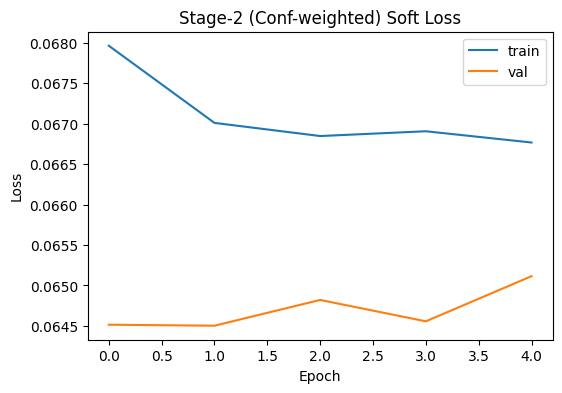

In [88]:
# =========================
# Cell 13c (REPLACE): Stage-2 self-training with CONFIDENCE WEIGHTING + entropy regularization
# =========================

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

EPOCHS_STAGE2 = 5          # keep short to avoid confirmation bias
LR_STAGE2 = 5e-4           # smaller LR for stability

# confidence weighting hyperparams
GAMMA_CONF = 3.0           # higher => downweight uncertain q more strongly
MIN_W = 0.05               # avoid zero gradients
MAX_W = 1.0

# entropy regularization (prevents overconfident logits)
LAMBDA_ENT = 0.02          # 0.005~0.02 good range

opt2 = torch.optim.AdamW(model.parameters(), lr=LR_STAGE2)

def bernoulli_entropy(p, eps=1e-6):
    p = p.clamp(eps, 1 - eps)
    return -(p * torch.log(p) + (1 - p) * torch.log(1 - p))

def conf_weight_from_q(q, gamma=2.0, min_w=0.05, max_w=1.0):
    """
    q in [0,1]. We want:
      - weight high when q near 0 or 1 (confident)
      - weight low when q near 0.5 (uncertain)
    Simple confidence score: conf = |q-0.5|*2 in [0,1]
    Then apply power gamma to sharpen.
    """
    conf = (q - 0.5).abs() * 2.0
    w = conf.pow(gamma)
    return w.clamp(min_w, max_w)

@torch.no_grad()
def eval_soft_loss(model, loader, device="cuda"):
    model.eval()
    total, n = 0.0, 0
    for batch in loader:
        xb = batch["X"].to(device)
        q  = batch["q"].to(device)

        logits = model(xb)
        bce_elem = F.binary_cross_entropy_with_logits(logits, q, reduction="none")
        w = conf_weight_from_q(q, gamma=GAMMA_CONF, min_w=MIN_W, max_w=MAX_W)
        loss = (bce_elem * w).mean()

        bs = xb.size(0)
        total += loss.item() * bs
        n += bs
    return total / max(n, 1)

def train_one_epoch_conf_st(model, loader, opt, device="cuda"):
    model.train()
    total, n = 0.0, 0

    for batch in tqdm(loader, desc="Stage2 Train (conf-weighted)", leave=False):
        xb = batch["X"].to(device)
        q  = batch["q"].to(device)

        logits = model(xb)
        p = torch.sigmoid(logits)

        # (1) confidence-weighted soft-target BCE  (== KL(q||p) up to constant, for Bernoulli)
        bce_elem = F.binary_cross_entropy_with_logits(logits, q, reduction="none")
        w = conf_weight_from_q(q, gamma=GAMMA_CONF, min_w=MIN_W, max_w=MAX_W)
        loss_soft = (bce_elem * w).mean()

        # (2) entropy regularization: discourage overconfident predictions
        ent = bernoulli_entropy(p).mean()
        loss = loss_soft + LAMBDA_ENT * ent

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        bs = xb.size(0)
        total += loss_soft.item() * bs
        n += bs

    return total / max(n, 1)

best_val = float("inf")
best_state = None
stage2_train_losses = []
stage2_val_losses = []

for ep in range(1, EPOCHS_STAGE2 + 1):
    tr = train_one_epoch_conf_st(model, train_loader_soft, opt2, device=device)
    va = eval_soft_loss(model, val_loader_soft, device=device)

    stage2_train_losses.append(tr)
    stage2_val_losses.append(va)

    print(f"[Stage2 ConfST] epoch {ep}/{EPOCHS_STAGE2} | train={tr:.4f} | val={va:.4f}")

    if va < best_val:
        best_val = va
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

if best_state is not None:
    model.load_state_dict(best_state)
    print("Loaded best Stage-2 model (confidence-weighted).")

# Plot Stage-2 losses (stability)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(stage2_train_losses, label="train")
plt.plot(stage2_val_losses, label="val")
plt.title("Stage-2 (Conf-weighted) Soft Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


HVR = 0.1950  (violations=197 / child_preds=1010)


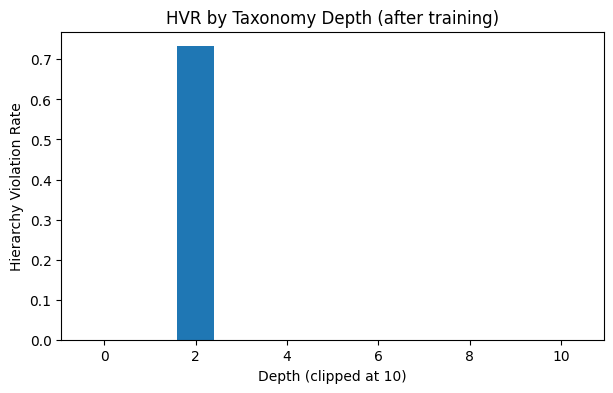

In [90]:
# =========================
# Post-Training: HVR evaluation (val) - stable sigmoid
# =========================

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

@torch.no_grad()
def predict_label_lists_rule(model, loader, device, thr=0.35, min_l=2, max_l=3):
    """
    Same rule as your evaluate_sample_f1 / submission:
    threshold + ensure min_l + cap max_l
    """
    model.eval()
    all_preds = []
    for batch in tqdm(loader, desc="Predicting for HVR", leave=False):
        Xb = batch["X"].to(device)
        probs = torch.sigmoid(model(Xb)).detach().cpu().numpy()  # ✅ stable

        for p in probs:
            idx = np.argsort(p)[::-1]
            chosen = [j for j in idx[:50] if p[j] >= thr]
            if len(chosen) < min_l:
                chosen = idx[:min_l].tolist()
            chosen = chosen[:max_l]
            all_preds.append(list(map(int, chosen)))
    return all_preds

def compute_depths(num_classes, parents):
    depths = np.full(num_classes, -1, dtype=int)
    roots = [c for c in range(num_classes) if len(parents.get(c, set())) == 0]

    from collections import deque
    q = deque(roots)
    for r in roots:
        depths[r] = 0

    children = {i: [] for i in range(num_classes)}
    for child, ps in parents.items():
        for p in ps:
            children[p].append(child)

    while q:
        u = q.popleft()
        for v in children[u]:
            nd = depths[u] + 1
            if depths[v] == -1 or nd < depths[v]:
                depths[v] = nd
                q.append(v)

    depths[depths == -1] = 0
    return depths

def compute_hvr(pred_labels, parents):
    total_child_preds = 0
    violations = 0
    for labs in pred_labels:
        S = set(labs)
        for c in labs:
            ps = parents.get(c, set())
            if len(ps) == 0:
                continue
            total_child_preds += 1
            if len(S.intersection(ps)) == 0:
                violations += 1
    return violations / max(total_child_preds, 1), violations, total_child_preds

def hvr_by_depth(pred_labels, parents, depths, max_depth=10):
    viol = np.zeros(max_depth+1, dtype=int)
    tot  = np.zeros(max_depth+1, dtype=int)

    for labs in pred_labels:
        S = set(labs)
        for c in labs:
            ps = parents.get(c, set())
            if len(ps) == 0:
                continue
            d = int(min(depths[c], max_depth))
            tot[d] += 1
            if len(S.intersection(ps)) == 0:
                viol[d] += 1

    rate = viol / np.maximum(tot, 1)
    return rate, viol, tot

pred_labels = predict_label_lists_rule(model, val_loader, device=device, thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS)

depths = compute_depths(NUM_CLASSES, parents)
hvr, v_cnt, child_cnt = compute_hvr(pred_labels, parents)
print(f"HVR = {hvr:.4f}  (violations={v_cnt} / child_preds={child_cnt})")

rate, viol, tot = hvr_by_depth(pred_labels, parents, depths, max_depth=10)
plt.figure(figsize=(7,4))
plt.bar(np.arange(len(rate)), rate)
plt.xlabel("Depth (clipped at 10)")
plt.ylabel("Hierarchy Violation Rate")
plt.title("HVR by Taxonomy Depth (after training)")
plt.show()


In [ ]:
pip install openTSNE

Doc repr: (1950, 256) | unique top1: 7
Label repr: (531, 256)


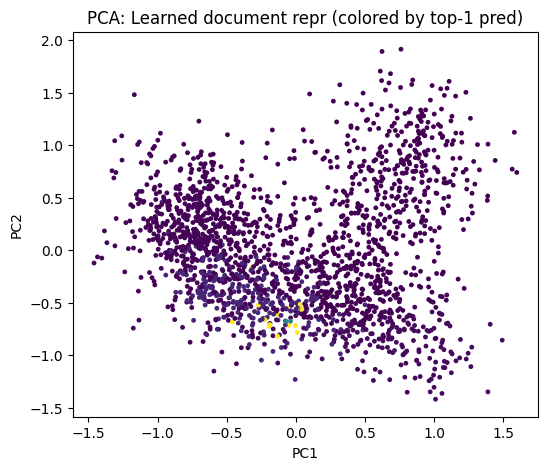

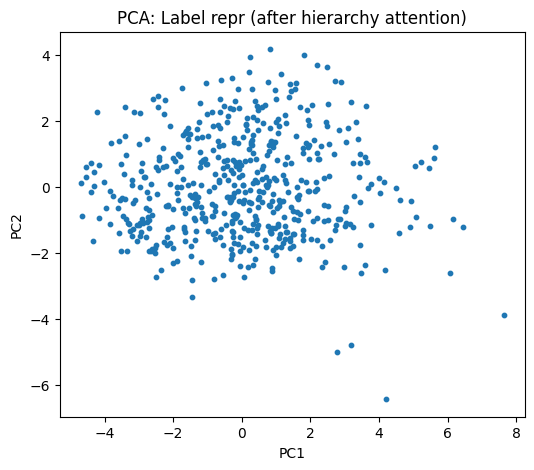

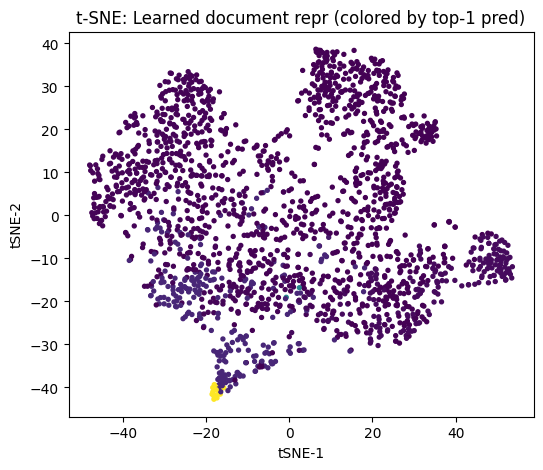

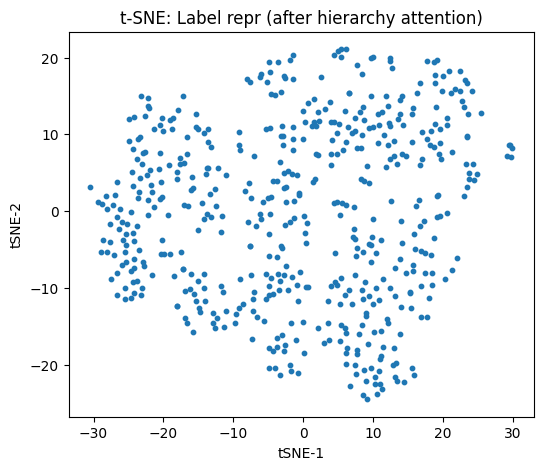

In [91]:
# =========================
# Cell 13 (UPDATE): PCA + t-SNE (learned doc repr + labels)
# =========================

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

@torch.no_grad()
def get_doc_repr(model, X_np, device="cuda", batch_size=256):
    model.eval()
    reps = []
    for i in range(0, len(X_np), batch_size):
        xb = torch.tensor(X_np[i:i+batch_size], dtype=torch.float32).to(device)
        h = model.doc_proj(xb)  # learned doc repr
        reps.append(h.detach().cpu().numpy())
    return np.vstack(reps)

@torch.no_grad()
def predict_top1(model, X_np, device="cuda", batch_size=256):
    model.eval()
    top1 = []
    for i in range(0, len(X_np), batch_size):
        xb = torch.tensor(X_np[i:i+batch_size], dtype=torch.float32).to(device)
        probs = torch.sigmoid(model(xb)).detach().cpu().numpy()
        top1.extend(list(np.argmax(probs, axis=1).astype(int)))
    return np.array(top1, dtype=int)

H_docs = get_doc_repr(model, X_va, device=device, batch_size=256)
doc_top1 = predict_top1(model, X_va, device=device, batch_size=256)

# label embeddings to visualize: use projected + attended E from the model
with torch.no_grad():
    E0 = model.label_proj(model.E_label_text).detach()  # [C, d]
    if model.mode == "gat":
        E_vis = model.label_attn(E0, model.edge_index).detach().cpu().numpy()
    else:
        E_vis = model.label_attn(E0, model.ancestors).detach().cpu().numpy()

print("Doc repr:", H_docs.shape, "| unique top1:", len(np.unique(doc_top1)))
print("Label repr:", E_vis.shape)

# PCA Docs
H_pca = PCA(n_components=2, random_state=42).fit_transform(H_docs)
plt.figure(figsize=(6,5))
plt.scatter(H_pca[:,0], H_pca[:,1], s=6, c=doc_top1)
plt.title("PCA: Learned document repr (colored by top-1 pred)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# PCA Labels
E_pca = PCA(n_components=2, random_state=42).fit_transform(E_vis)
plt.figure(figsize=(6,5))
plt.scatter(E_pca[:,0], E_pca[:,1], s=10)
plt.title("PCA: Label repr (after hierarchy attention)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

# t-SNE Docs (subsample)
MAX_DOCS_TSNE = 2000
if len(H_docs) > MAX_DOCS_TSNE:
    idx = np.random.RandomState(42).choice(len(H_docs), MAX_DOCS_TSNE, replace=False)
    H_in = H_docs[idx]
    c_in = doc_top1[idx]
else:
    H_in = H_docs
    c_in = doc_top1

H_tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42).fit_transform(H_in)
plt.figure(figsize=(6,5))
plt.scatter(H_tsne[:,0], H_tsne[:,1], s=8, c=c_in)
plt.title("t-SNE: Learned document repr (colored by top-1 pred)")
plt.xlabel("tSNE-1"); plt.ylabel("tSNE-2")
plt.show()

# t-SNE Labels
E_tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42).fit_transform(E_vis)
plt.figure(figsize=(6,5))
plt.scatter(E_tsne[:,0], E_tsne[:,1], s=10)
plt.title("t-SNE: Label repr (after hierarchy attention)")
plt.xlabel("tSNE-1"); plt.ylabel("tSNE-2")
plt.show()


In [92]:
# =========================
# Submission (UPDATE): stable sigmoid + sorted labels + pid column
# =========================

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import os, json

X_test = np.load(os.path.join(ART_DIR, "test_bert.npy"))
test_ids = json.load(open(os.path.join(ART_DIR, "test_ids.json"), "r"))

@torch.no_grad()
def predict_test_labels_rule(model, X_np, device="cuda",
                             thr=0.35, min_l=2, max_l=3, batch_size=256):
    model.eval()
    all_labels = []
    for i in tqdm(range(0, len(X_np), batch_size), desc="Predicting test", leave=False):
        xb = torch.tensor(X_np[i:i+batch_size], dtype=torch.float32).to(device)
        probs = torch.sigmoid(model(xb)).detach().cpu().numpy()

        for p in probs:
            idx = np.argsort(p)[::-1]
            chosen = [j for j in idx[:50] if p[j] >= thr]
            if len(chosen) < min_l:
                chosen = idx[:min_l].tolist()
            chosen = chosen[:max_l]
            chosen = sorted(map(int, chosen))
            all_labels.append(",".join(map(str, chosen)))
    return all_labels

pred_strs = predict_test_labels_rule(
    model, X_test, device=device,
    thr=THR, min_l=MIN_LABELS, max_l=MAX_LABELS,
    batch_size=256
)

sub = pd.DataFrame({"id": test_ids, "labels": pred_strs})
SUB_PATH = os.path.join(ART_DIR, f"submission_attn_{model.mode}.csv")
sub.to_csv(SUB_PATH, index=False)
print("✅ Saved submission:", SUB_PATH)
sub.head()


✅ Saved submission: ./artifacts_Experiment4_GAT/submission_attn_path.csv


,id,labels
0,0,"0,3"
1,1,"3,21,40"
2,2,"0,3"
3,3,"0,313"
4,4,"0,10"
